In [1]:
import pandas as pd
import os

In [88]:
meta_df = pd.read_csv('nvidia_delivery.csv')

In [26]:
df_sensor = pd.read_csv('all_ts.csv')

In [51]:
df_sensor.head()

,id,time,x,y,z
0,incident-0-19c58199-ada2-417e-b616-8e2389171bc6,1.633833e+09,0.022,1.033,-0.134
1,incident-0-19c58199-ada2-417e-b616-8e2389171bc6,1.633833e+09,0.022,1.033,-0.134
2,incident-0-19c58199-ada2-417e-b616-8e2389171bc6,1.633833e+09,0.024,1.033,-0.134
3,incident-0-19c58199-ada2-417e-b616-8e2389171bc6,1.633833e+09,0.022,1.035,-0.136
4,incident-0-19c58199-ada2-417e-b616-8e2389171bc6,1.633833e+09,0.020,1.035,-0.134


In [29]:
df = df_sensor.loc[df_sensor['id']=='003341ed-22bb-4a31-91f0-38b97785eab6'].reset_index(drop=True)

In [34]:
df = df.set_index('id')

In [46]:
import numpy as np
df['g'] = np.sqrt(df['x']**2 + (1 - df['y'])**2 + df['z']**2)

In [49]:
import matplotlib.pyplot as plt

def plot_time_series(df):
    # Set up the figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Extract time and sensor data
    time = df.iloc[:, 0]  # First column is timestamp
    # x_data = df.iloc[:, 1]  # Second column is x-axis
    # y_data = df.iloc[:, 2]  # Third column is y-axis
    # z_data = df.iloc[:, 3]  # Fourth column is z-axis
    g_data = df.iloc[:, 4]  # Fourth column is z-axis

    # Plot the three axes
    # ax.plot(time, x_data, label='X-axis', alpha=0.8)
    # ax.plot(time, y_data, label='Y-axis', alpha=0.8)
    # ax.plot(time, z_data, label='Z-axis', alpha=0.8)
    ax.plot(time, g_data, label='G', alpha=0.8)

    # Add labels and legend
    ax.set_title('Accelerometer Data')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Acceleration (G force)')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

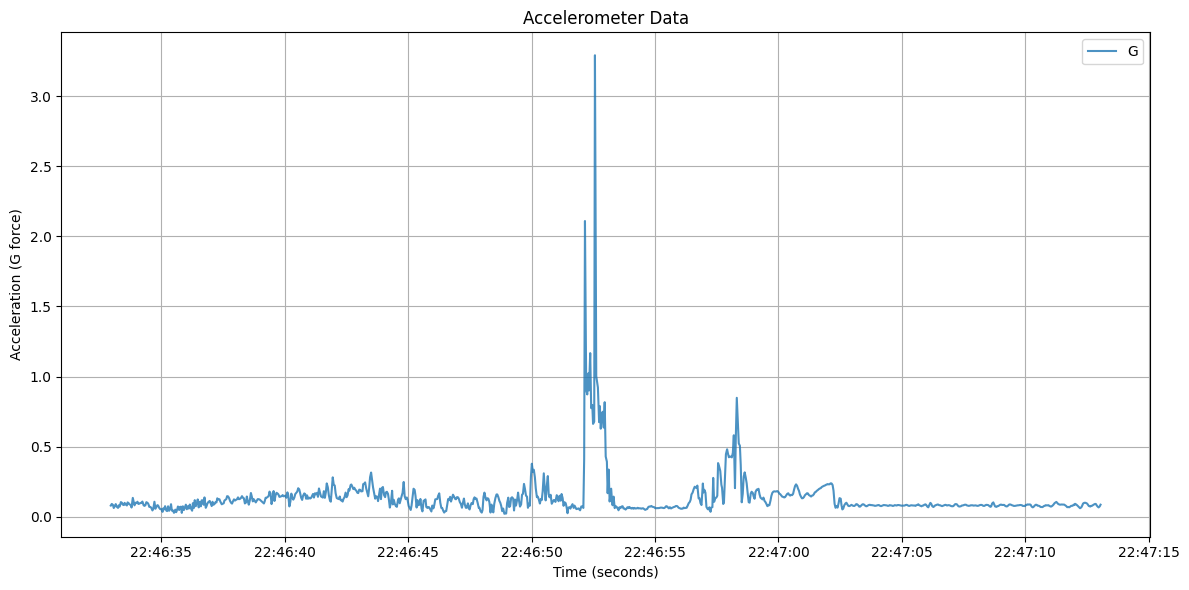

In [50]:
plot_time_series(df)

In [53]:
features = pd.read_csv('extract_features_all.csv', index_col=[0])
df_audio = pd.concat([pd.read_csv('peak_audio_features_train.csv'), pd.read_csv('peak_audio_features_test.csv')]).drop('label',axis=1)
train_ids = pd.read_csv('df_train_collision.csv').id
test_ids = pd.read_csv('df_test_collision.csv').id
len(train_ids), len(test_ids)

(55693, 13923)

In [63]:
train_ids = train_ids[train_ids.isin(df_audio['video_id'])]
test_ids = test_ids[test_ids.isin(df_audio['video_id'])]
train_ids = train_ids[train_ids.isin(features.index)]
test_ids = test_ids[test_ids.isin(features.index)]
len(train_ids), len(test_ids)

(31581, 4928)

In [75]:
fi = pd.read_csv('features_iteration_13.csv')['feature_name'].to_list()
features = features[fi + ['collision_label']]

In [77]:
from simpml.tabular.all import *

indexsplitter = IndexSplitter(
    split_sets = {
            Dataset.Train: train_ids, Dataset.Valid: test_ids
        }
)

data_manager = SupervisedTabularDataManager(
    data = features,
    target = 'collision_label',
    prediction_type = PredictionType.BinaryClassification,
    splitter = indexsplitter, 
)

data_manager.build_pipeline(
    remove_special_json_characters=False,
    step_params = {'encoding_dict': {'normal':0,'collision':1}},
    smote=False
)

X_train,y_train = data_manager.get_training_data()
exp_mang = ExperimentManager(data_manager, optimize_metric = MetricName.AUC)
exp_mang.remove_models(['LightGBM', 'Support Vector Classifier','AdaBoost Classifier','Decision Tree','Gradient Boosting'])
exp_mang.run_experiment(metrics_kwargs = {'pos_label': 1})

,Experiment ID,Experiment Description,Model,Model Description,Data Version,Data Description,Model Params,Metric Params,Accuracy,AUC,Recall,Precision,Balanced Accuracy,F1,Run Time
0,20250407153127_dfd3,,Baseline Classification,Default settings,bf02d33b,,"{'experiment_manager': Prediction Type: PredictionType.BinaryClassification, Metric: Metric: AUC. Description: , Random State: 0}",{'pos_label': 1},0.801745,0.483315,0.096998,0.066879,0.483315,0.079171,0:00:00
1,20250407153127_dfd3,,Logistic Regression,Default settings,bf02d33b,,"{'experiment_manager': Prediction Type: PredictionType.BinaryClassification, Metric: Metric: AUC. Description: , Random State: 0}",{'pos_label': 1},0.964083,0.835265,0.678984,0.885542,0.835265,0.768627,0:00:02
2,20250407153127_dfd3,,Random Forest,Default settings,bf02d33b,,"{'experiment_manager': Prediction Type: PredictionType.BinaryClassification, Metric: Metric: AUC. Description: , Random State: 0}",{'pos_label': 1},0.966518,0.848078,0.704388,0.891813,0.848078,0.787097,0:00:09
3,20250407153127_dfd3,,XGBoost,Default settings,bf02d33b,,"{'experiment_manager': Prediction Type: PredictionType.BinaryClassification, Metric: Metric: AUC. Description: , Random State: 0}",{'pos_label': 1},0.967127,0.860934,0.732102,0.873278,0.860934,0.796482,0:00:13


In [79]:
from tsfresh_script import *

In [91]:
best_model_imu = exp_mang.get_best_model()

X, y = data_manager.get_validation_data()

y_pred = best_model_imu.model.predict(X)
y_prod = best_model_imu.model.predict_proba(X)

preds = pd.DataFrame({
    'id': X.index,
    'y_pred': y_pred,
    'y_true': y,
    'y_prob_0': y_prod[:, 0],
    'y_prob_1': y_prod[:, 1]
})

preds = preds.merge(meta_df[['id', 'g_max']], on='id', how='left')
preds.head()

,id,y_pred,y_true,y_prob_0,y_prob_1,g_max
0,6a08ff3918e6118930d4cfc92af29b40,0,0,0.995845,0.004155,0.544604
1,6e35f6a3af98736625def05e41613587,0,0,0.999689,0.000311,0.990723
2,7b26e7daa15b5c7088369d39c5f09026,0,0,0.998964,0.001036,0.910070
3,5d603c7fedaa293fba02ac9e16c4cbfa,0,0,0.955807,0.044193,1.144686
4,178968770e47cf68437d2afbcfd2f89c,0,0,0.999964,0.000036,0.789226



=== Analyzing Segment: g_max < 1.0 ===
Segment size: 3965 samples


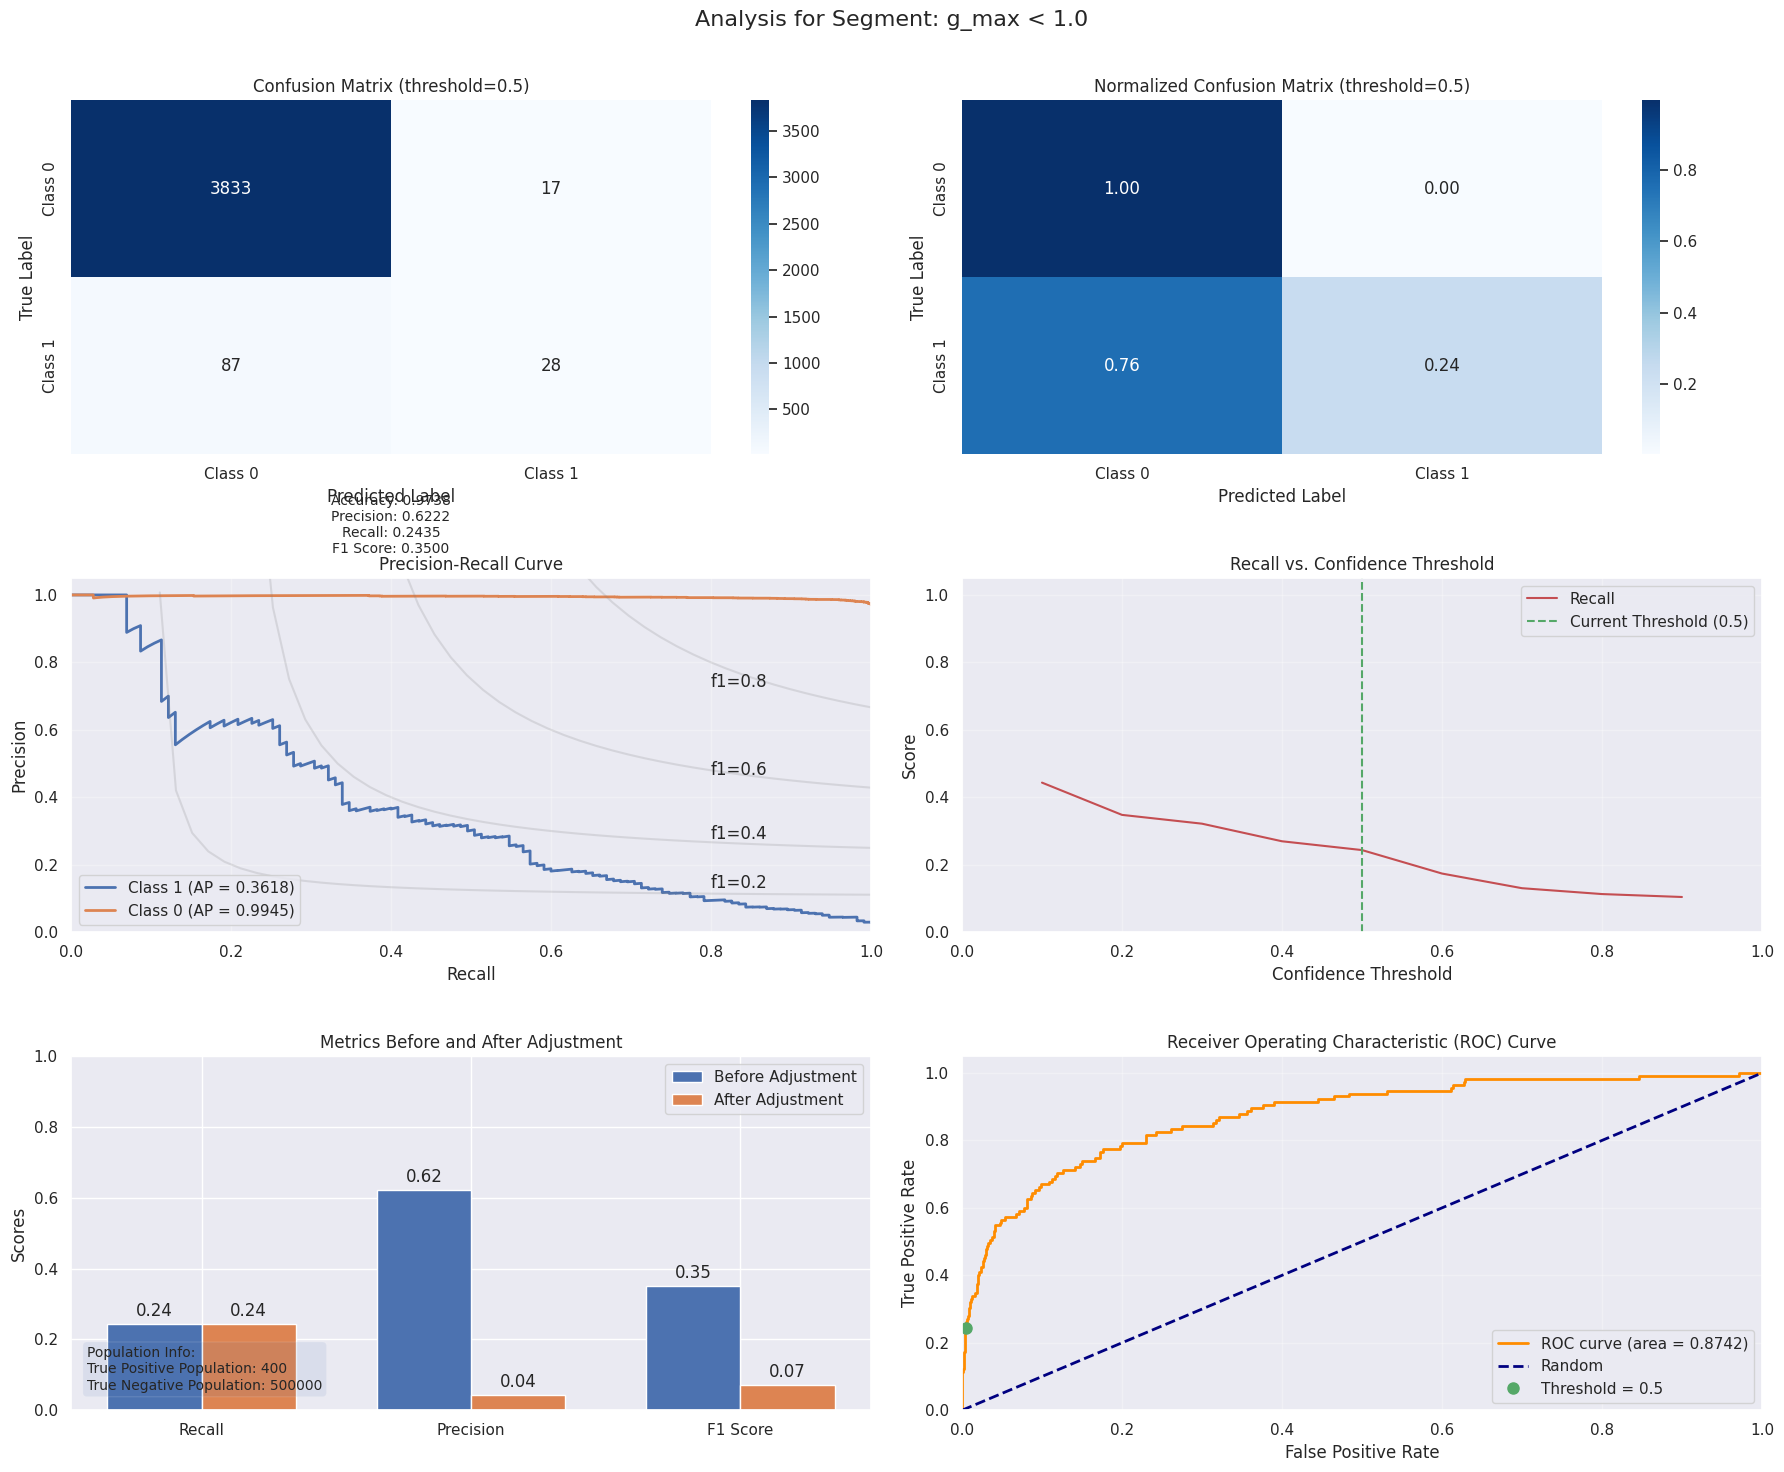


Segment: g_max < 1.0
True Positive Population: 400
True Negative Population: 500000
Samples: 3965
TN: 3833
FP: 17
FN: 87
TP: 28
Recall: 0.2435
Precision: 0.6222
F1: 0.3500
ROC_AUC: 0.8742
Precision_adj: 0.0422
F1_adj: 0.0720
Pop_TP: 400
Pop_TN: 500000

=== Analyzing Segment: 1.0 ≤ g_max < 1.4 ===
Segment size: 587 samples


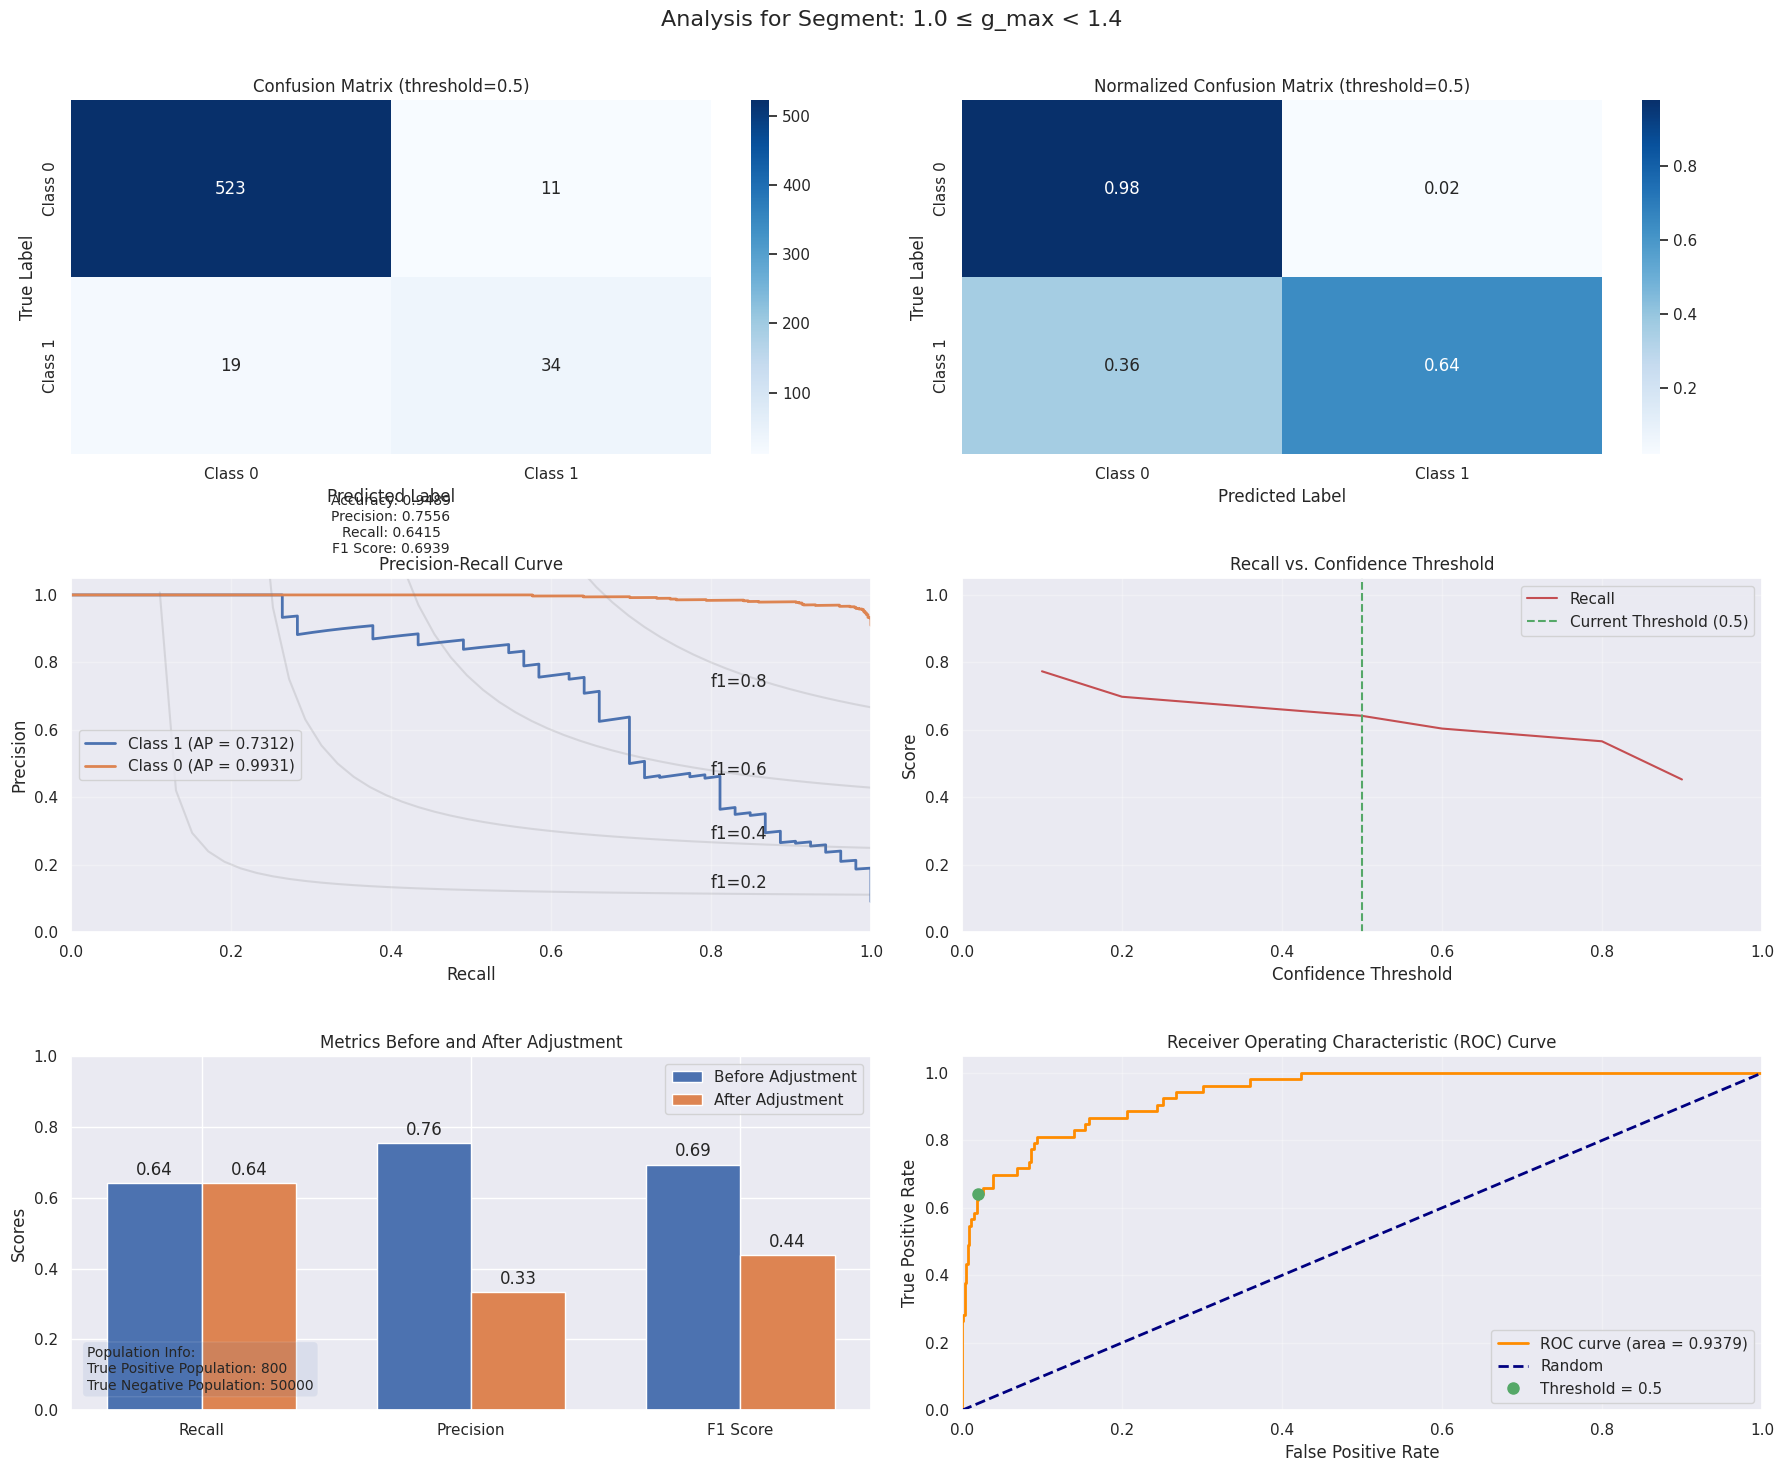


Segment: 1.0 ≤ g_max < 1.4
True Positive Population: 800
True Negative Population: 50000
Samples: 587
TN: 523
FP: 11
FN: 19
TP: 34
Recall: 0.6415
Precision: 0.7556
F1: 0.6939
ROC_AUC: 0.9379
Precision_adj: 0.3326
F1_adj: 0.4380
Pop_TP: 800
Pop_TN: 50000

=== Analyzing Segment: g_max ≥ 1.4 ===
Segment size: 376 samples


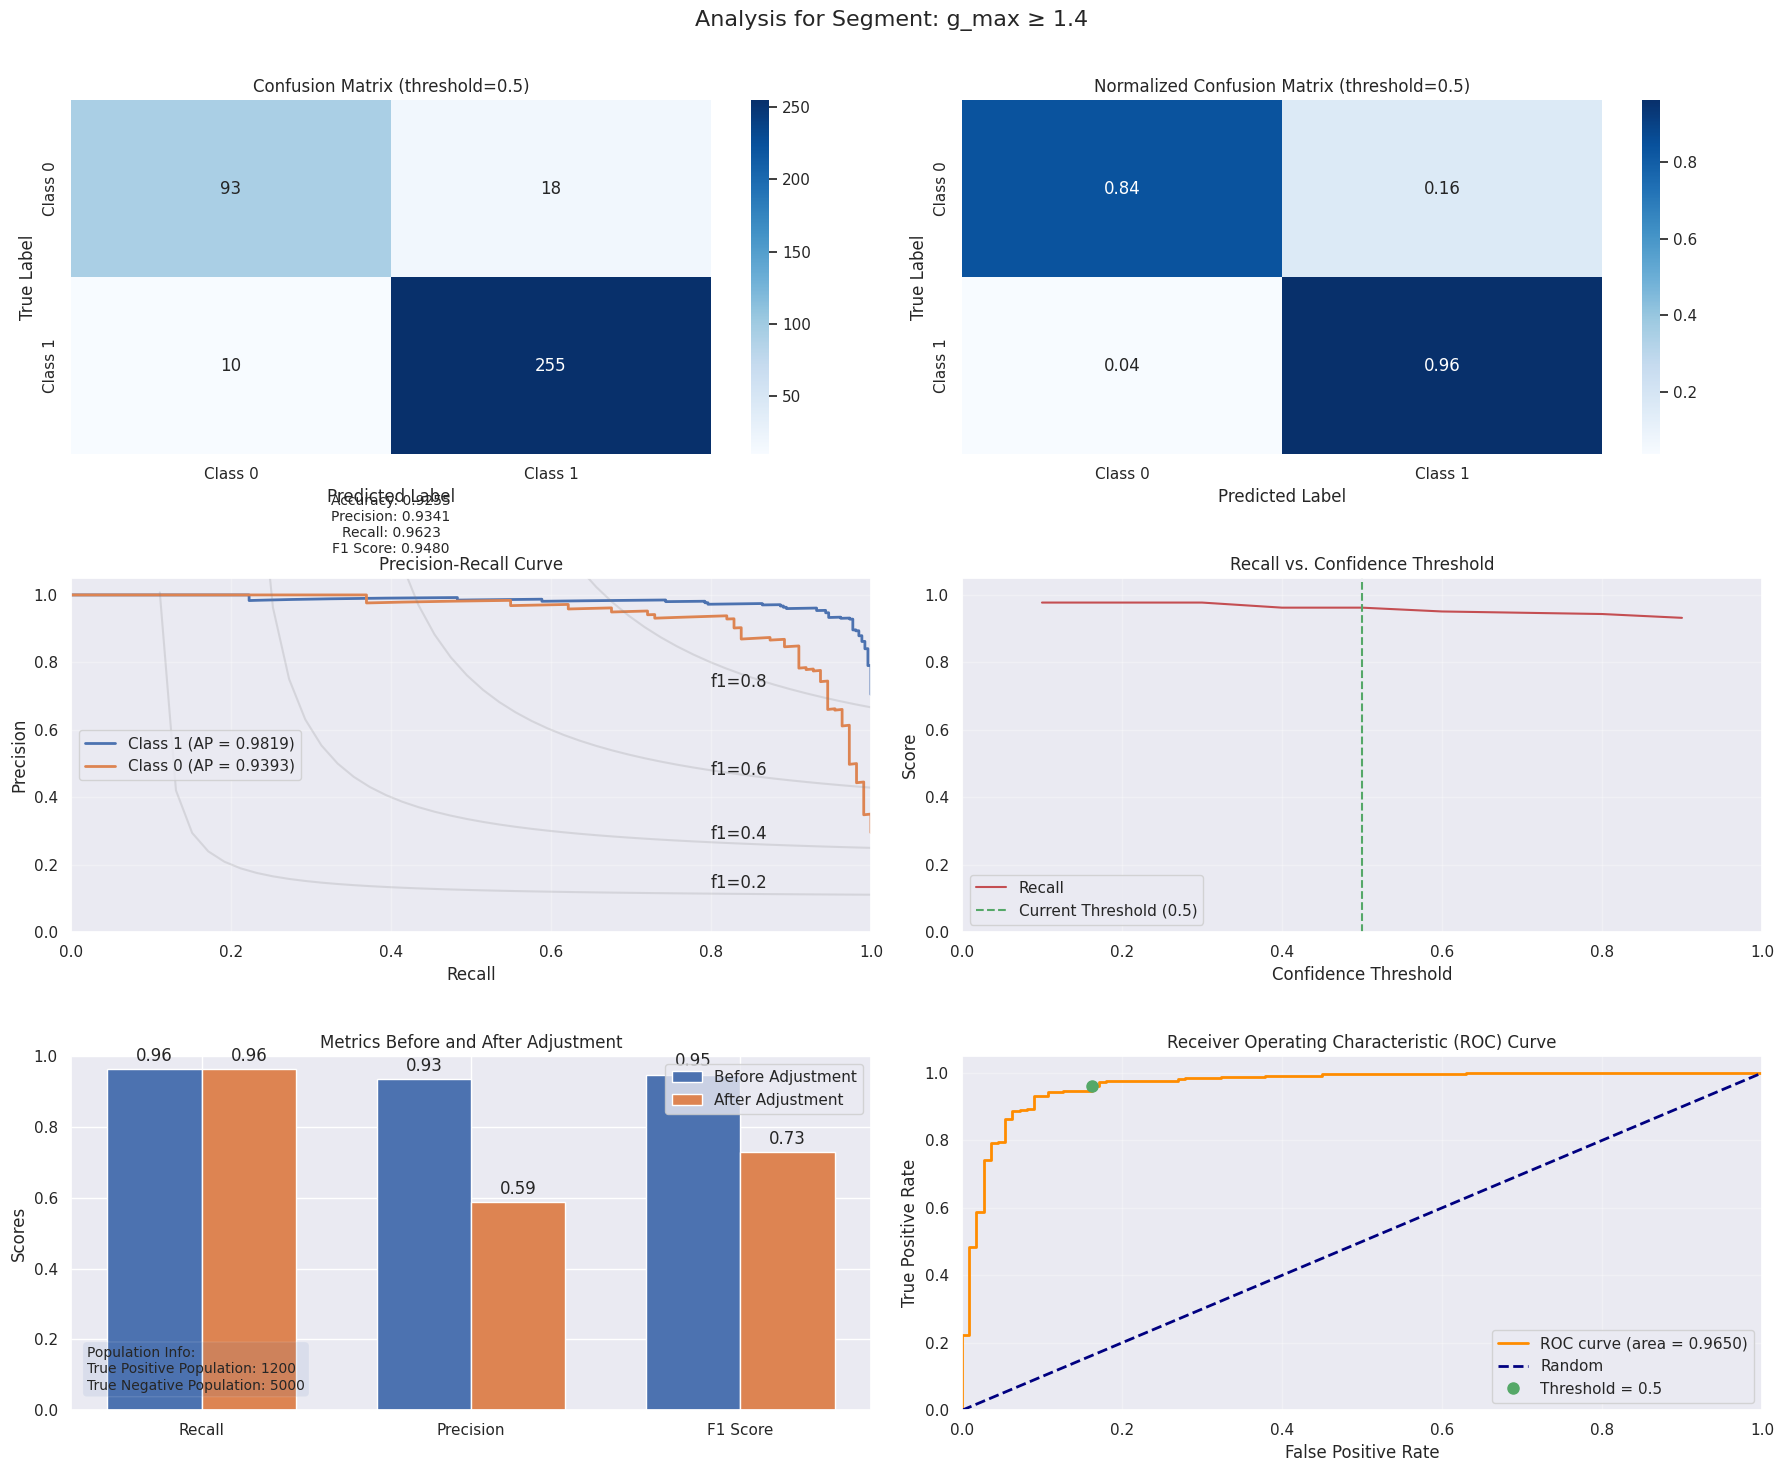


Segment: g_max ≥ 1.4
True Positive Population: 1200
True Negative Population: 5000
Samples: 376
TN: 93
FP: 18
FN: 10
TP: 255
Recall: 0.9623
Precision: 0.9341
F1: 0.9480
ROC_AUC: 0.9650
Precision_adj: 0.5875
F1_adj: 0.7296
Pop_TP: 1200
Pop_TN: 5000


In [92]:
analyzer_imu = SegmentAnalyzer(preds, 'g_max')
analyzer_imu.add_segment(None, 1.0, true_pos_population=400, true_neg_population=500000)
analyzer_imu.add_segment(1.0, 1.4, true_pos_population=800, true_neg_population=50000)
analyzer_imu.add_segment(1.4, None, true_pos_population=1200, true_neg_population=5000)
results = analyzer_imu.analyze(y_true_col='y_true', y_prob_cols=['y_prob_0', 'y_prob_1'])
summary_df = analyzer_imu.summary()

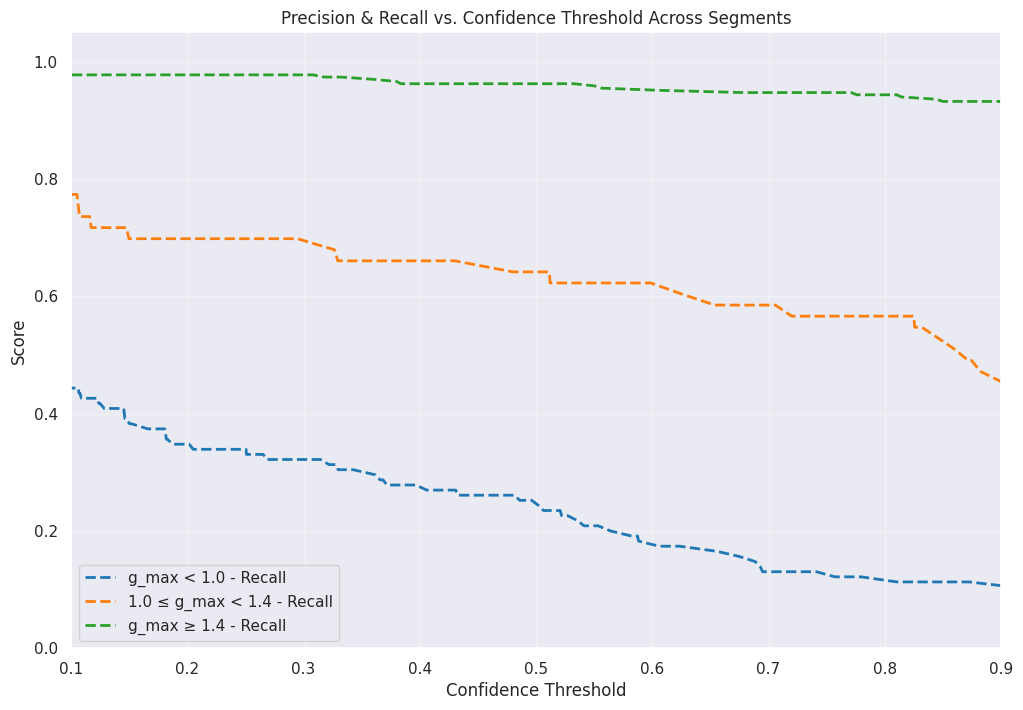

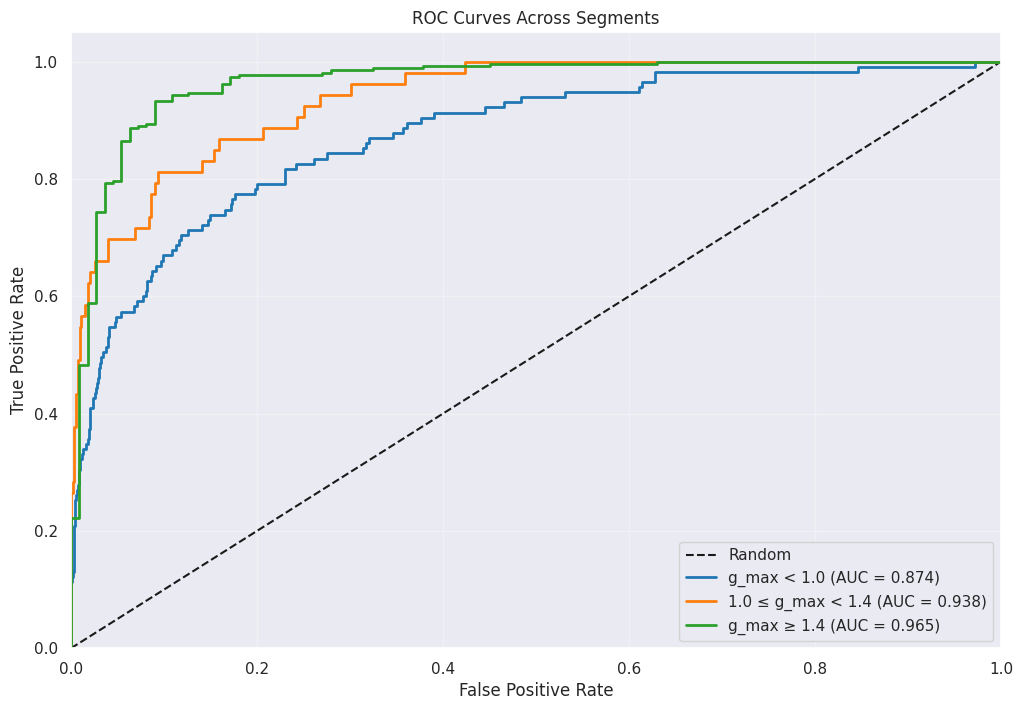

In [93]:
metrics_fig, pop_fig, data_point_imu = analyzer_imu.plot_segment_comparisons(
    y_true_col='y_true',
    y_prob_cols=['y_prob_0', 'y_prob_1'],
    metric_type='recall'
)

In [94]:
interp = TabularInterpreterBinaryClassification(
    model = best_model_imu,
    data_manager = data_manager,
    opt_metric = exp_mang.opt_metric,
    pos_class = {'pos_class' : 1},
    shap_timeout=300
)
fi = interp.get_feature_importance()
fi = fi.sort_values('feature_importance_vals', ascending=False)
fi.loc[fi['feature_importance_vals']>0.0]

 98%|===================| 4821/4928 [00:18<00:00]          

,col_name,feature_importance_vals
0,x__mean_n_absolute_max__number_of_maxima_7,0.018361
1,"z__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""var""",0.014423
2,"z__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8",0.014247
3,z__absolute_maximum,0.013981
4,x__last_location_of_maximum,0.012615
...,...,...
284,"y__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.2",0.000642
285,"z__fft_coefficient__attr_""imag""__coeff_79",0.000589
286,"x__fft_coefficient__attr_""imag""__coeff_14",0.000543
287,"y__fft_coefficient__attr_""angle""__coeff_24",0.000533


In [97]:
fi = fi.loc[fi['feature_importance_vals']>0.0]

In [96]:
meta_df['video_type'] = meta_df['video_type'].replace({
    'nv_collision_reviewed': 'collision',
    'nv_collision_full_annotation': 'collision'
})
meta_df['video_type'] = meta_df['video_type'].apply(lambda x: 'normal' if x != 'collision' else x)

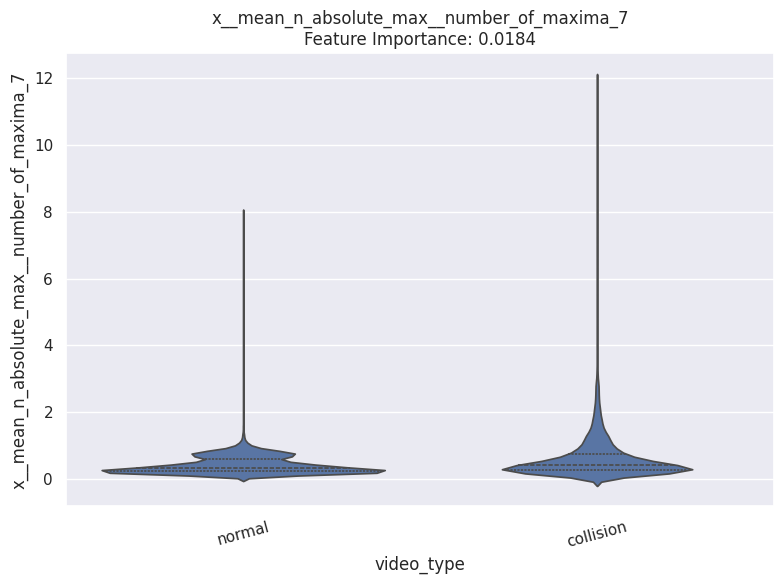

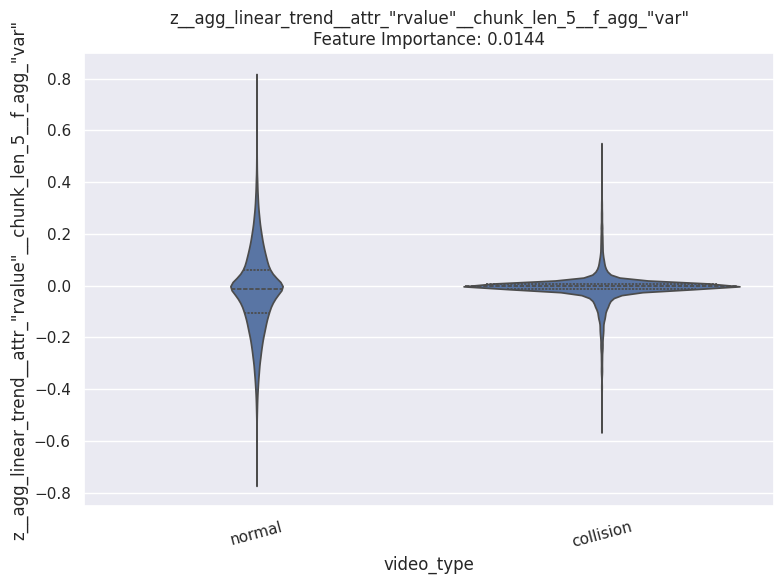

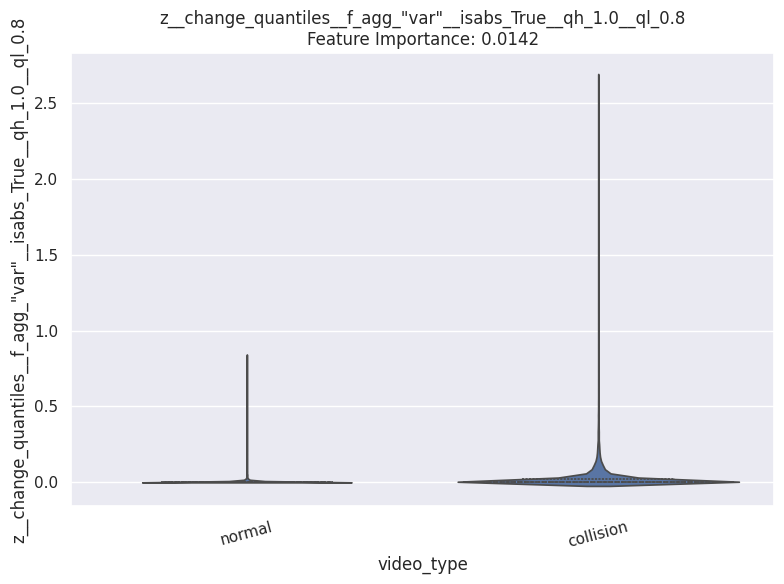

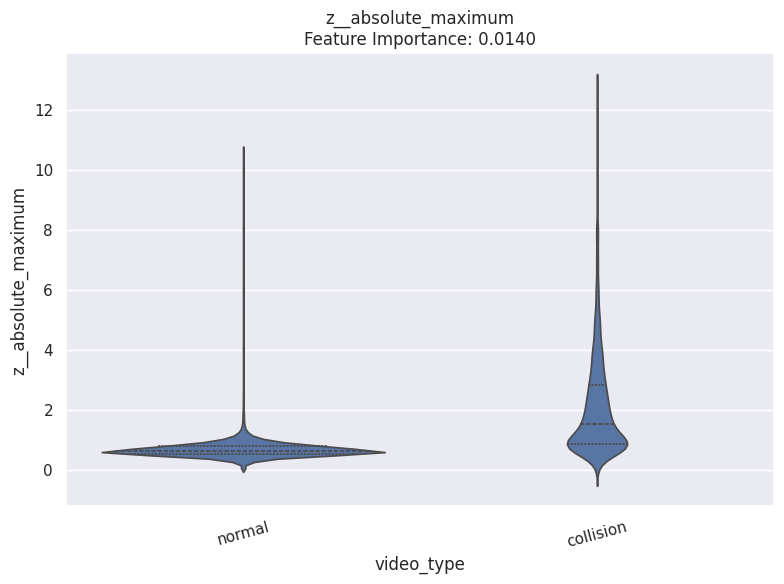

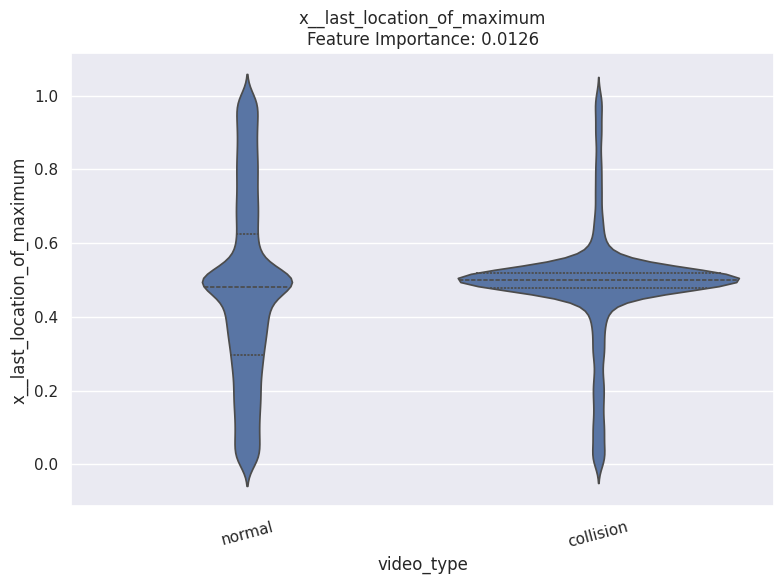

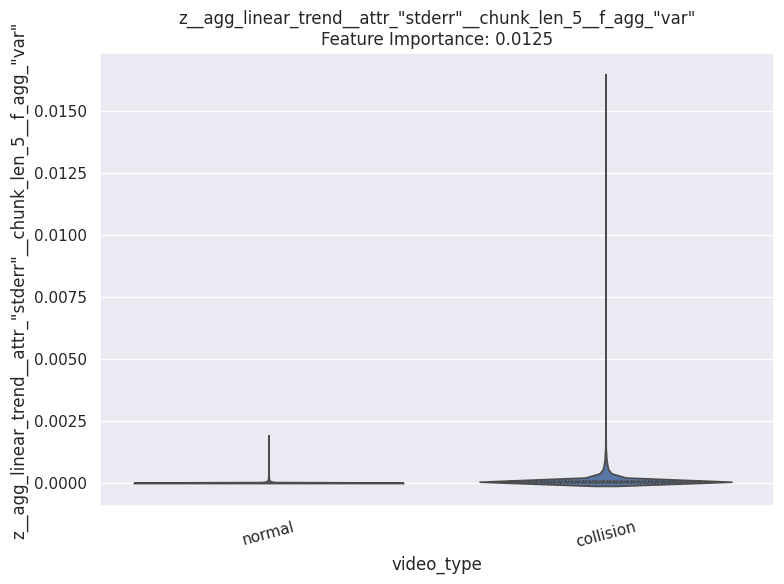

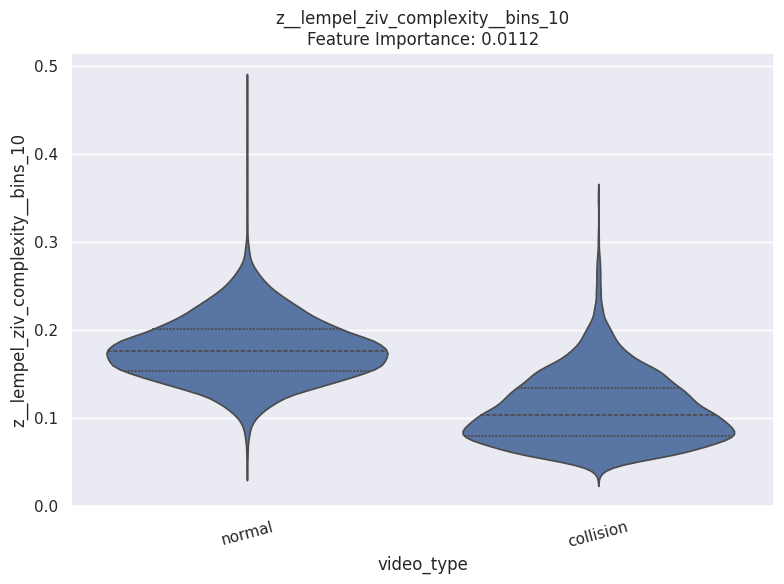

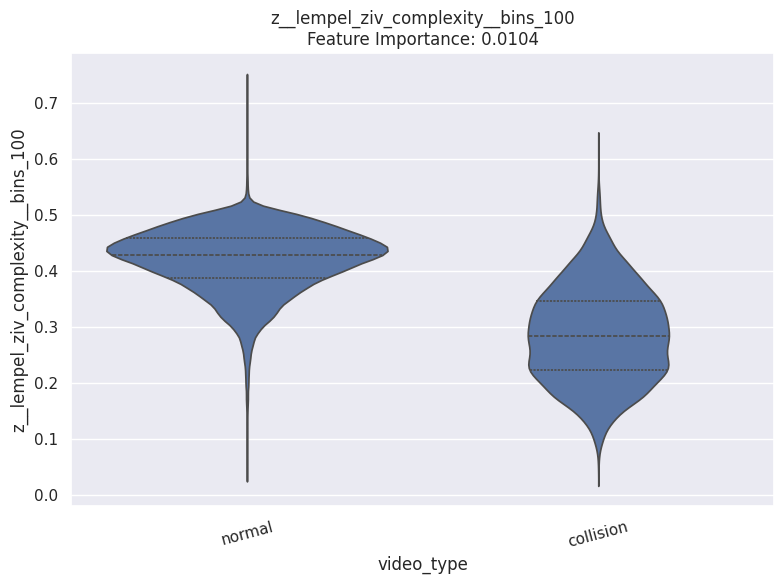

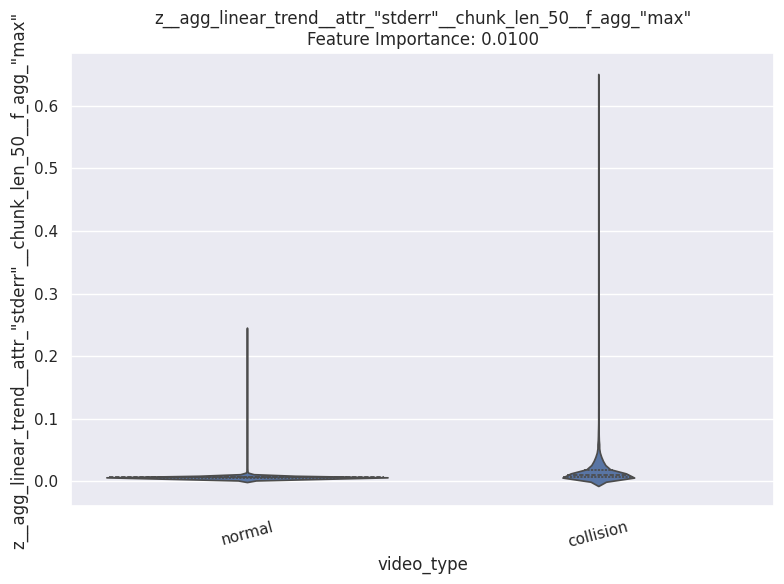

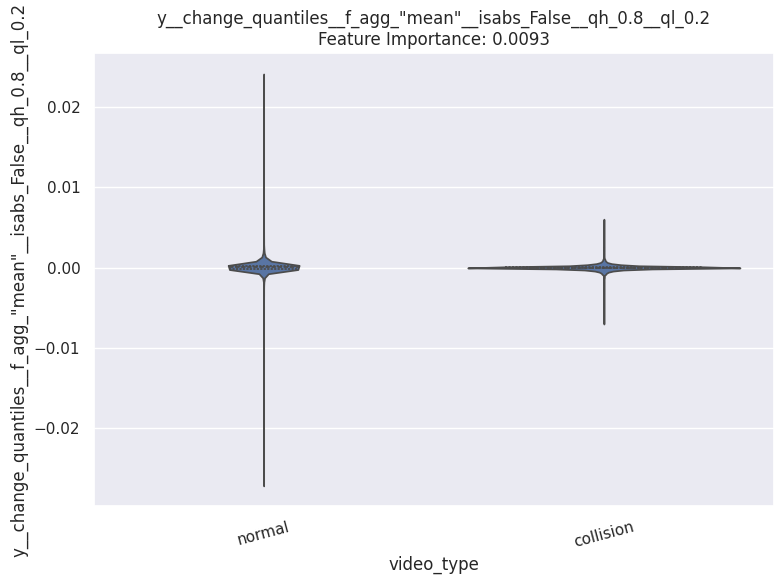

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# Make sure 'id' columns are of type str for merging
meta_df['id'] = meta_df['id'].astype(str)
features.index = features.index.astype(str)

n = 10
top_features = fi.sort_values('feature_importance_vals', ascending=False).head(n)

for _, row in top_features.iterrows():
    feature_name = row['col_name']
    importance_val = row['feature_importance_vals']
    
    if feature_name not in features.columns:
        continue 

    merged_df = meta_df.merge(features[[feature_name]], left_on='id', right_index=True)

    plt.figure(figsize=(8, 6))
    sns.violinplot(
        x='video_type',
        y=feature_name,
        data=merged_df,
        inner='quartile'
    )
    plt.title(f"{feature_name}\nFeature Importance: {importance_val:.4f}")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()


In [102]:
features

,"z__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8",z__absolute_maximum,"z__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""var""",x__lempel_ziv_complexity__bins_3,x__mean_n_absolute_max__number_of_maxima_7,z__lempel_ziv_complexity__bins_10,z__lempel_ziv_complexity__bins_100,z__binned_entropy__max_bins_10,"z__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""var""",x__large_standard_deviation__r_0.1,...,"x__fft_coefficient__attr_""real""__coeff_11",z__ratio_beyond_r_sigma__r_0.5,"y__fft_coefficient__attr_""imag""__coeff_64",y__index_mass_quantile__q_0.3,z__autocorrelation__lag_5,"z__fft_coefficient__attr_""real""__coeff_78","x__fft_coefficient__attr_""abs""__coeff_49","y__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.2","y__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)",collision_label
000049dd8b9406d24fb225d3cac9cbcf,0.000976,0.838020,0.087636,0.131814,0.517589,0.201189,0.483647,2.008992,0.000002,1.0,...,0.698975,0.648167,-1.956333,0.302279,0.939654,-0.495852,2.301344,0.000095,0.039762,normal
000147cc5fca05f5b9b7992981190242,0.001597,0.624625,-0.312065,0.078358,0.931268,0.182836,0.394776,1.584870,0.000004,1.0,...,18.434444,0.429851,-7.837863,0.301493,0.738519,-5.506645,4.444483,0.000023,0.035511,normal
0001beb8085197d17d48a1ea461c86d3,0.000282,0.452703,-0.142321,0.075510,1.061117,0.216327,0.478571,1.976103,0.000002,1.0,...,-0.256845,0.554082,-0.475805,0.298980,0.902119,0.878406,1.183955,0.000061,0.009269,normal
0001ee227361e6ea1c9534a1d4e10415,0.000528,0.606324,-0.147835,0.075681,0.508463,0.201816,0.477296,1.850915,0.000003,0.0,...,-10.800682,0.623613,-3.768475,0.300706,0.869714,2.750705,5.085678,0.000136,0.019651,normal
00025101c58e65246dbd3dd615e2ef14,0.000358,0.656129,-0.091897,0.083415,0.188138,0.167812,0.413150,1.661988,0.000001,0.0,...,1.069838,0.393523,-0.214756,0.300294,0.962906,0.505493,0.125732,0.000007,-0.003737,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
incident-ff86cca08315a28687ee31c206f478ec,0.003832,1.167844,0.031053,0.045420,0.220603,0.093918,0.273287,0.589812,0.000014,0.0,...,0.017429,0.177829,2.255048,0.300231,0.191882,-1.548755,1.125968,0.000005,0.005018,collision
incident-ffa036a6848105d12434196e1df3b88c,0.085523,4.145195,0.003472,0.091816,0.624463,0.059880,0.189621,0.206708,0.000153,0.0,...,-3.625711,0.186627,0.228291,0.300399,0.606242,5.571748,3.623655,0.000011,0.010563,collision
incident-ffbe349d3461d3ed7c9b6c0221270a79,0.031816,2.476844,0.000444,0.050860,1.732621,0.099476,0.191473,0.493781,0.000031,0.0,...,-0.892667,0.075542,2.849420,0.299925,0.586535,9.193204,13.516666,0.000007,-0.015000,collision
incident-fff753450b3a9e0abb9cea89e5800728,0.050237,5.911000,0.004901,0.042662,2.657286,0.069113,0.170648,0.742062,0.000680,0.0,...,-7.962329,0.965870,-14.256570,0.643345,0.619421,-7.471683,11.495846,0.000257,0.031374,collision


,Experiment ID,Experiment Description,Model,Model Description,Data Version,Data Description,Model Params,Metric Params,Accuracy,AUC,Recall,Precision,Balanced Accuracy,F1,Run Time
0,20250407155555_1cf8,,Baseline Classification,Default settings,230fc0aa,,"{'experiment_manager': Prediction Type: PredictionType.BinaryClassification, Metric: Metric: AUC. Description: , Random State: 0}",{'pos_label': 1},0.804383,0.501457,0.133949,0.089645,0.501457,0.107407,0:00:00
1,20250407155555_1cf8,,Logistic Regression,Default settings,230fc0aa,,"{'experiment_manager': Prediction Type: PredictionType.BinaryClassification, Metric: Metric: AUC. Description: , Random State: 0}",{'pos_label': 1},0.966924,0.861866,0.734411,0.868852,0.861866,0.795995,0:00:02
2,20250407155555_1cf8,,Random Forest,Default settings,230fc0aa,,"{'experiment_manager': Prediction Type: PredictionType.BinaryClassification, Metric: Metric: AUC. Description: , Random State: 0}",{'pos_label': 1},0.967127,0.854673,0.718245,0.886040,0.854673,0.793367,0:00:08
3,20250407155555_1cf8,,XGBoost,Default settings,230fc0aa,,"{'experiment_manager': Prediction Type: PredictionType.BinaryClassification, Metric: Metric: AUC. Description: , Random State: 0}",{'pos_label': 1},0.970373,0.874192,0.757506,0.888889,0.874192,0.817955,0:00:14



=== Analyzing Segment: g_max < 1.0 ===
Segment size: 3965 samples


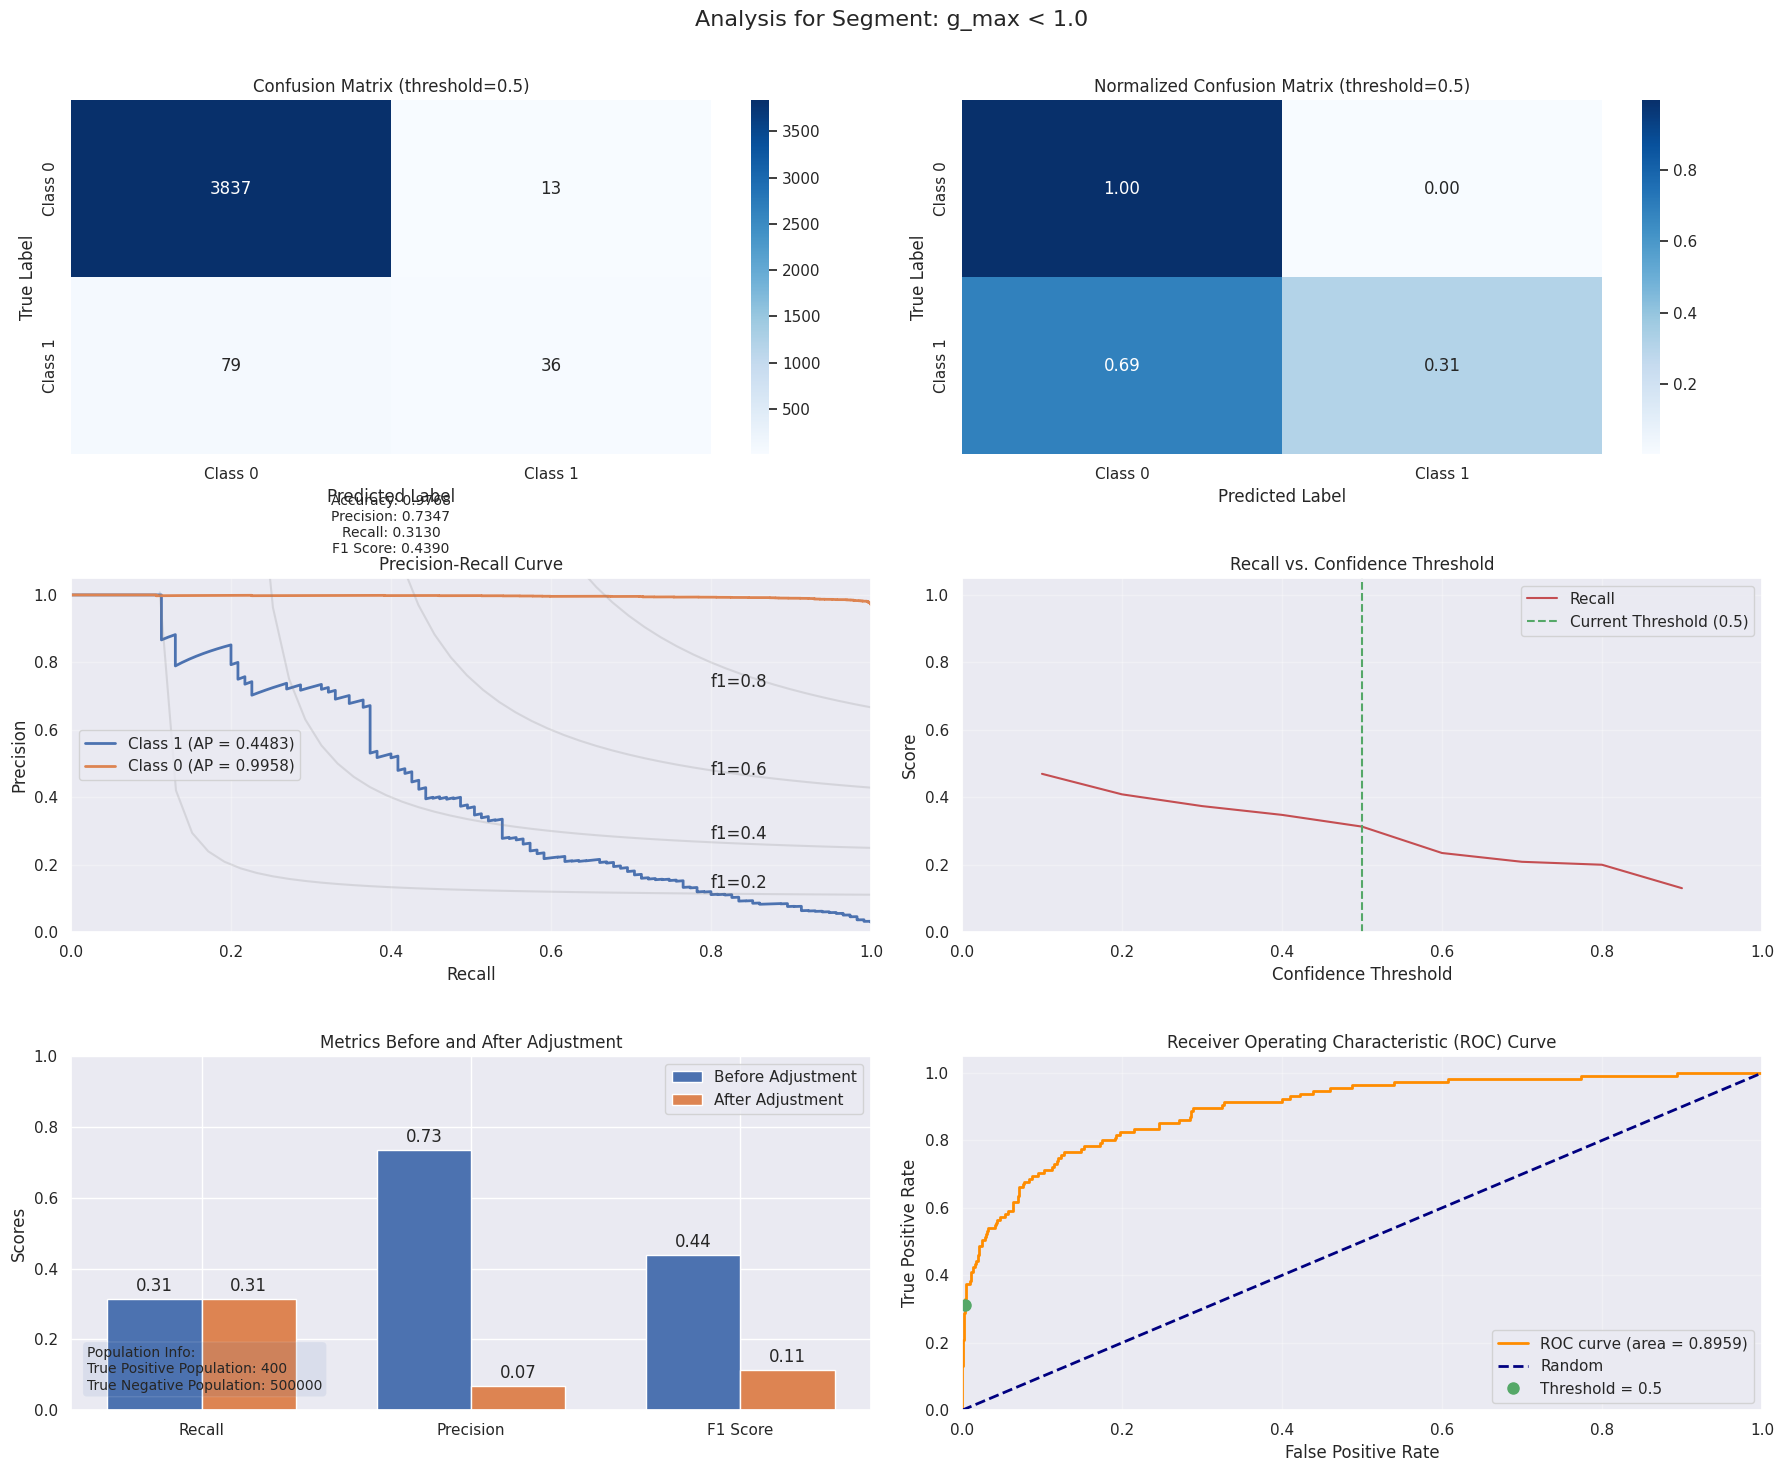


Segment: g_max < 1.0
True Positive Population: 400
True Negative Population: 500000
Samples: 3965
TN: 3837
FP: 13
FN: 79
TP: 36
Recall: 0.3130
Precision: 0.7347
F1: 0.4390
ROC_AUC: 0.8959
Precision_adj: 0.0690
F1_adj: 0.1131
Pop_TP: 400
Pop_TN: 500000

=== Analyzing Segment: 1.0 ≤ g_max < 1.4 ===
Segment size: 587 samples


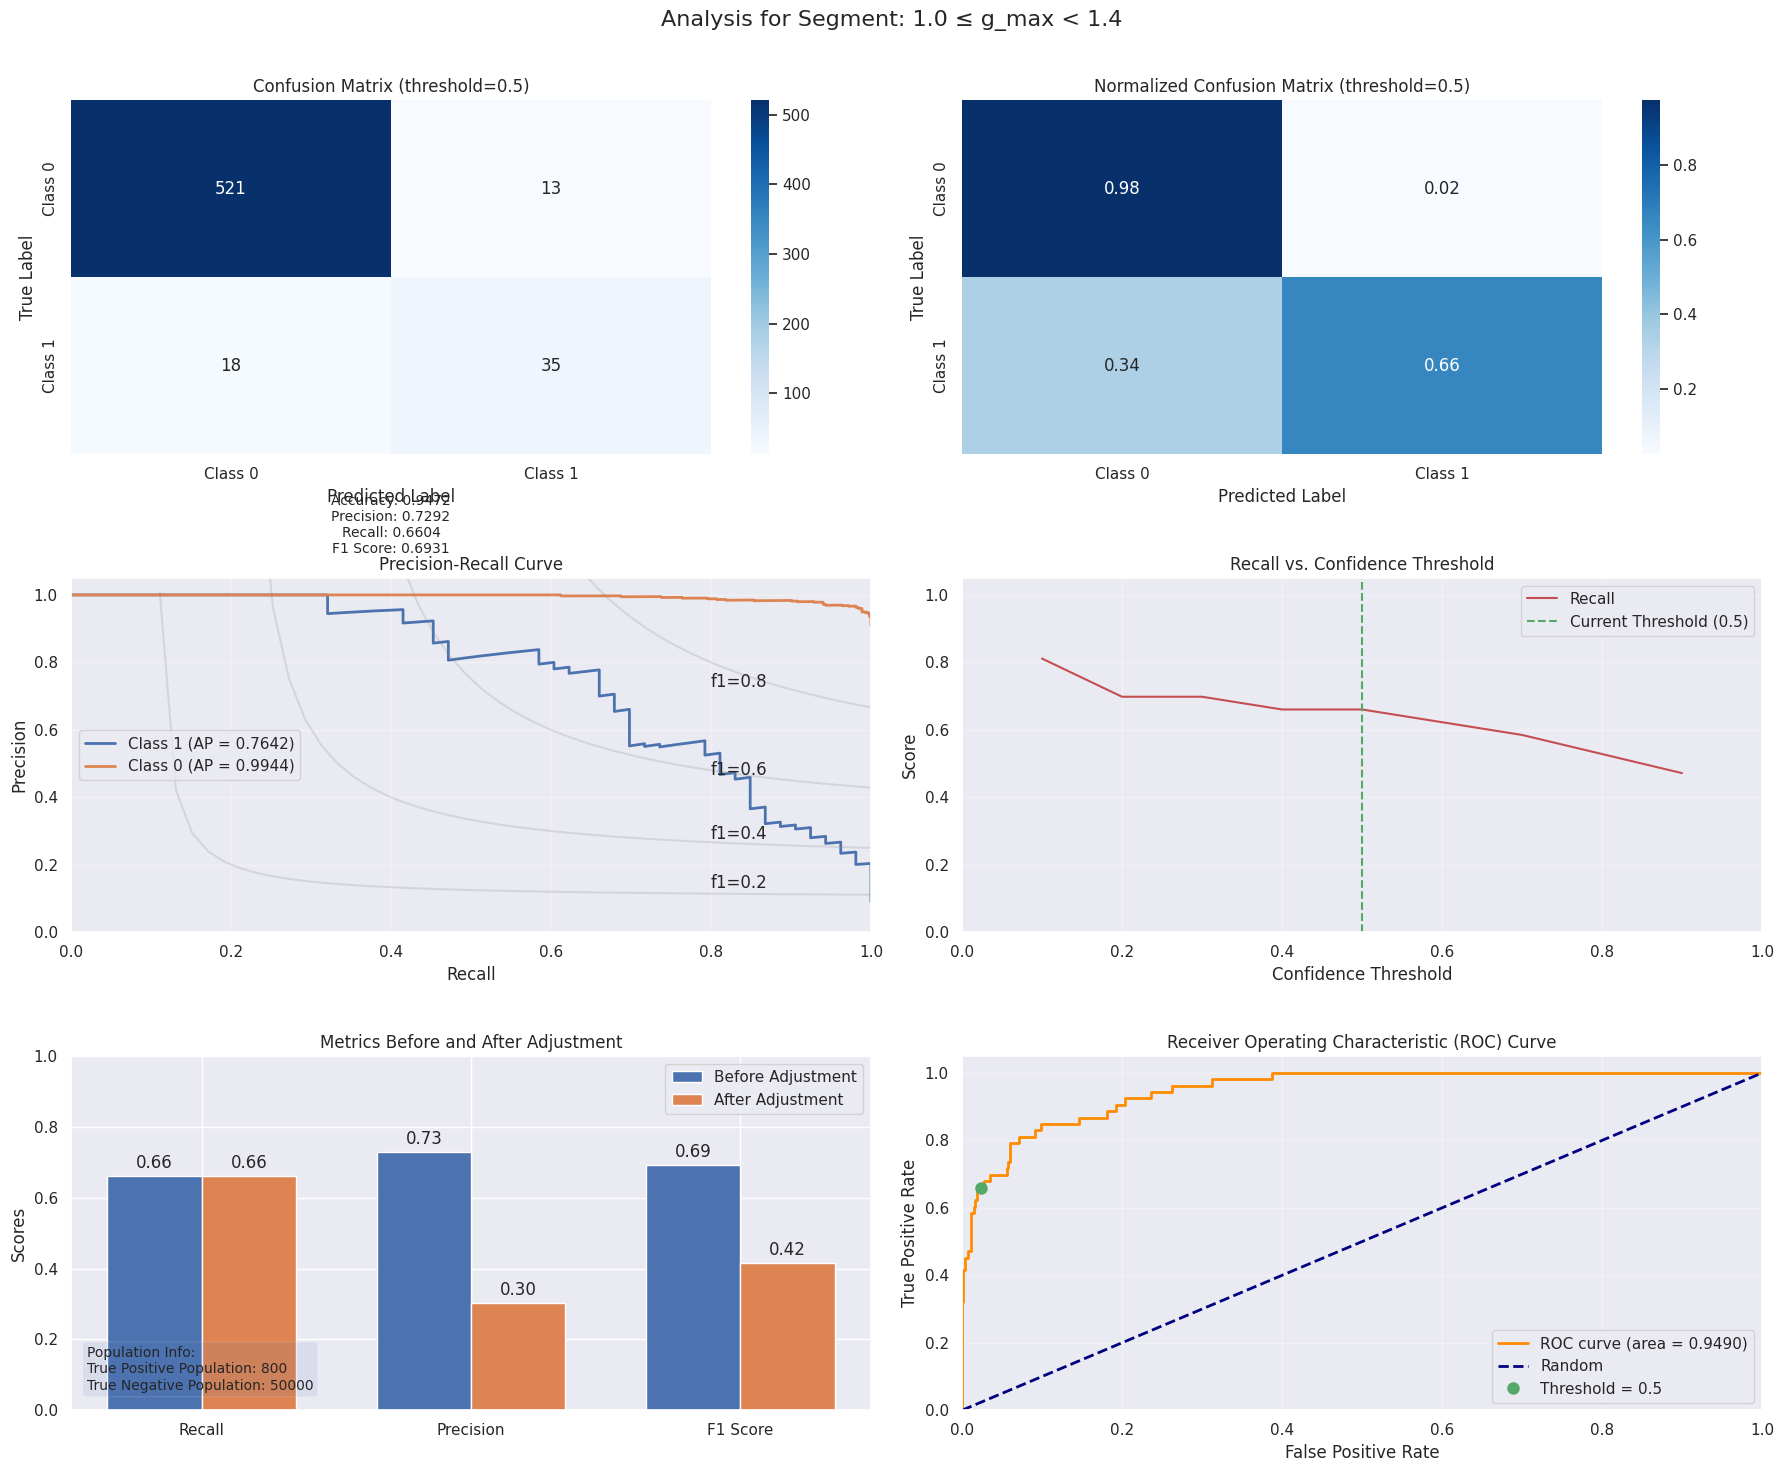


Segment: 1.0 ≤ g_max < 1.4
True Positive Population: 800
True Negative Population: 50000
Samples: 587
TN: 521
FP: 13
FN: 18
TP: 35
Recall: 0.6604
Precision: 0.7292
F1: 0.6931
ROC_AUC: 0.9490
Precision_adj: 0.3027
F1_adj: 0.4151
Pop_TP: 800
Pop_TN: 50000

=== Analyzing Segment: g_max ≥ 1.4 ===
Segment size: 376 samples


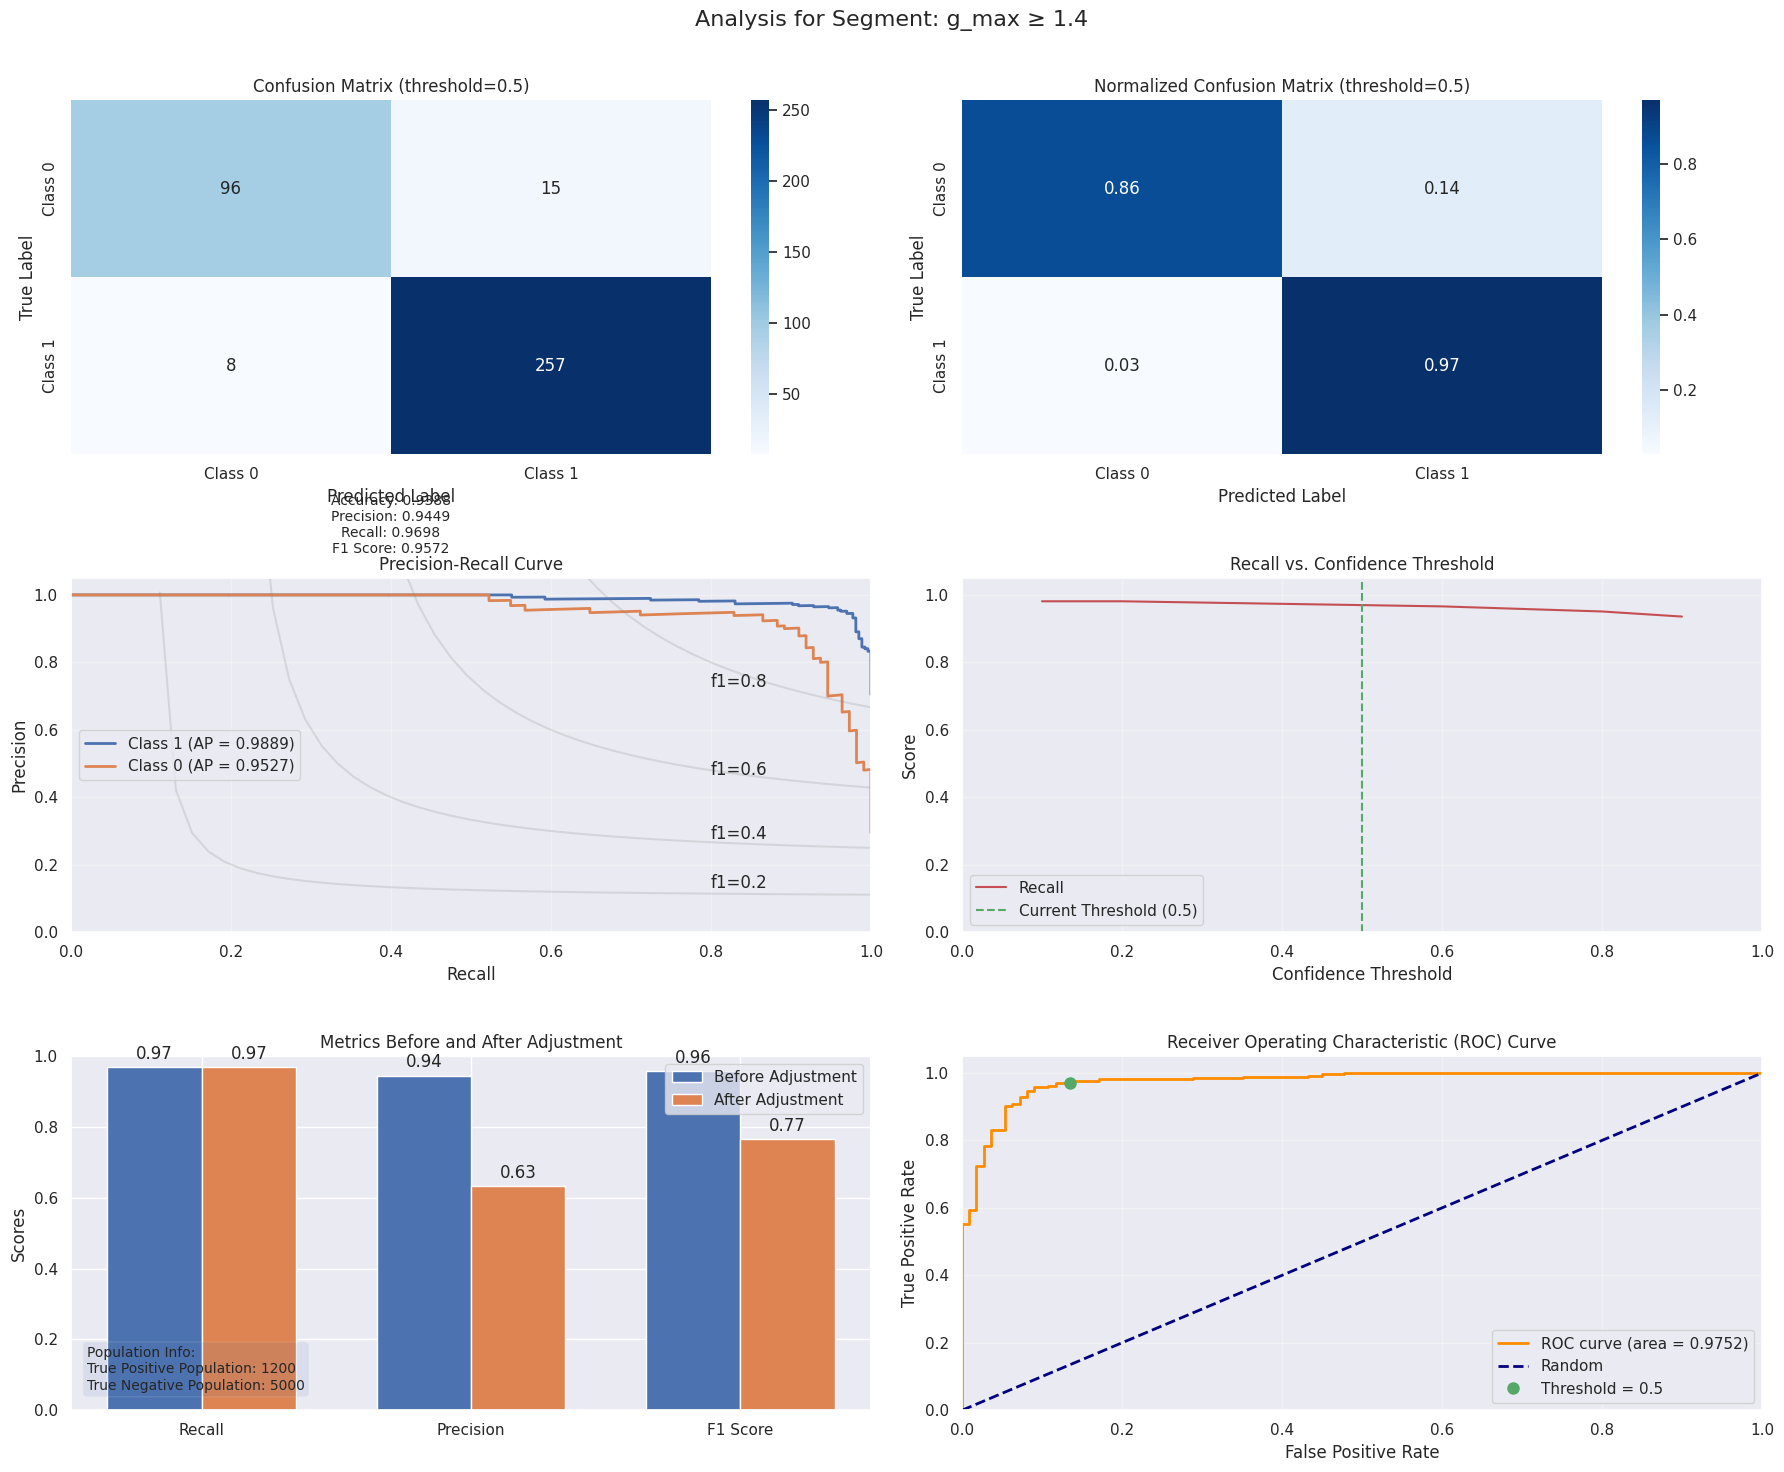


Segment: g_max ≥ 1.4
True Positive Population: 1200
True Negative Population: 5000
Samples: 376
TN: 96
FP: 15
FN: 8
TP: 257
Recall: 0.9698
Precision: 0.9449
F1: 0.9572
ROC_AUC: 0.9752
Precision_adj: 0.6327
F1_adj: 0.7658
Pop_TP: 1200
Pop_TN: 5000


100%|===================| 31494/31581 [01:58<00:00]        

Caught an ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was -7.853426, while the model output was -7.849772. If this difference is acceptable you can set check_additivity=False to disable this check.
Running without check_additivity which might lead to inaccurate results!


 33%|=======             | 10356/31581 [00:39<01:19]       

In [ ]:
from simpml.tabular.all import *

df_features_with_audio = df_audio.merge(features.reset_index(), left_on="video_id", right_on="index", how="inner")
df_features_with_audio = df_features_with_audio.set_index('video_id').drop('index', axis=1)
df_features_with_audio.head()

indexsplitter = IndexSplitter(
    split_sets = {
            Dataset.Train: train_ids, Dataset.Valid: test_ids
        }
)

data_manager = SupervisedTabularDataManager(
    data = df_features_with_audio,
    target = 'collision_label',
    prediction_type = PredictionType.BinaryClassification,
    splitter = indexsplitter, 
)

data_manager.build_pipeline(
    remove_special_json_characters=False,
    step_params = {'encoding_dict': {'normal':0,'collision':1}},
    smote=False
)

X_train,y_train = data_manager.get_training_data()
exp_mang = ExperimentManager(data_manager, optimize_metric = MetricName.AUC)
exp_mang.remove_models(['LightGBM', 'Support Vector Classifier','AdaBoost Classifier','Decision Tree','Gradient Boosting'])
exp_mang.run_experiment(metrics_kwargs = {'pos_label': 1})

best_model_imu_audio = exp_mang.get_best_model()

X, y = data_manager.get_validation_data()

y_pred = best_model_imu_audio.model.predict(X)
y_prod = best_model_imu_audio.model.predict_proba(X)

preds = pd.DataFrame({
    'id': X.index,
    'y_pred': y_pred,
    'y_true': y,
    'y_prob_0': y_prod[:, 0],
    'y_prob_1': y_prod[:, 1]
})

preds = preds.merge(meta_df[['id', 'g_max']], on='id', how='left')
preds.head()

analyzer_imu = SegmentAnalyzer(preds, 'g_max')
analyzer_imu.add_segment(None, 1.0, true_pos_population=400, true_neg_population=500000)
analyzer_imu.add_segment(1.0, 1.4, true_pos_population=800, true_neg_population=50000)
analyzer_imu.add_segment(1.4, None, true_pos_population=1200, true_neg_population=5000)
results = analyzer_imu.analyze(y_true_col='y_true', y_prob_cols=['y_prob_0', 'y_prob_1'])
summary_df = analyzer_imu.summary()

metrics_fig, pop_fig, data_point_imu = analyzer_imu.plot_segment_comparisons(
    y_true_col='y_true',
    y_prob_cols=['y_prob_0', 'y_prob_1'],
    metric_type='recall'
)

interp = TabularInterpreterBinaryClassification(
    model = best_model_imu_audio,
    data_manager = data_manager,
    opt_metric = exp_mang.opt_metric,
    pos_class = {'pos_class' : 1},
    shap_timeout=300
)
fi = interp.get_feature_importance()
fi = fi.sort_values('feature_importance_vals', ascending=False)
fi.loc[fi['feature_importance_vals']>0.0]

meta_df['video_type'] = meta_df['video_type'].replace({
    'nv_collision_reviewed': 'collision',
    'nv_collision_full_annotation': 'collision'
})
meta_df['video_type'] = meta_df['video_type'].apply(lambda x: 'normal' if x != 'collision' else x)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# Make sure 'id' columns are of type str for merging
meta_df['id'] = meta_df['id'].astype(str)
features.index = features.index.astype(str)

n = 10
top_features = fi.sort_values('feature_importance_vals', ascending=False).head(n)

for _, row in top_features.iterrows():
    feature_name = row['col_name']
    importance_val = row['feature_importance_vals']
    
    if feature_name not in features.columns:
        continue 

    merged_df = meta_df.merge(features[[feature_name]], left_on='id', right_index=True)

    plt.figure(figsize=(8, 6))
    sns.violinplot(
        x='video_type',
        y=feature_name,
        data=merged_df,
        inner='quartile'
    )
    plt.title(f"{feature_name}\nFeature Importance: {importance_val:.4f}")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()